# Winter Data
Cabled Array - Axial Base Deep Profiler (Axial Seamount)
18 December, 2018 00:00:00 to 19 December, 2018 00:00:00

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import requests
import datetime

In [5]:
data = pd.read_csv("cabled_array_abdp.csv")
data.head()

,obs,time,deployment,conductivity_millisiemens,driver_timestamp,ingestion_timestamp,internal_timestamp,port_timestamp,preferred_timestamp,pressure,...,conductivity_millisiemens_qc_executed,conductivity_millisiemens_qc_results,dpc_ctd_seawater_conductivity_qc_executed,dpc_ctd_seawater_conductivity_qc_results,density_qc_executed,density_qc_results,practical_salinity_qc_executed,practical_salinity_qc_results,lat,lon
0,"('0',)",3.754140e+09,3,31.354500,3.773776e+09,3.773777e+09,3.754140e+09,0.0,internal_timestamp,2414.389893,...,1,0,29,13,29,29,29,29,45.82972,-129.75904
1,"('1',)",3.754140e+09,3,31.354900,3.773776e+09,3.773777e+09,3.754140e+09,0.0,internal_timestamp,2414.659912,...,1,0,29,13,29,29,29,29,45.82972,-129.75904
2,"('2',)",3.754140e+09,3,31.354700,3.773776e+09,3.773777e+09,3.754140e+09,0.0,internal_timestamp,2414.919922,...,1,0,29,13,29,29,29,29,45.82972,-129.75904
3,"('3',)",3.754140e+09,3,31.354900,3.773776e+09,3.773777e+09,3.754140e+09,0.0,internal_timestamp,2415.139893,...,1,0,29,13,29,29,29,29,45.82972,-129.75904
4,"('4',)",3.754140e+09,3,31.355101,3.773776e+09,3.773777e+09,3.754140e+09,0.0,internal_timestamp,2415.399902,...,1,0,29,13,29,29,29,29,45.82972,-129.75904


In [6]:
data.shape

(34055, 30)

In [7]:
#Defining parameters
ABDP_time = data.time
pres = data.pressure #same as depth as dbar is one to one to meters
sal = data.practical_salinity
T = data.temp

C:\Users\ctaing\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([737046.75 , 737046.875, 737047.   , 737047.125, 737047.25 ,
        737047.375, 737047.5  , 737047.625]),
 <a list of 8 Text xticklabel objects>)

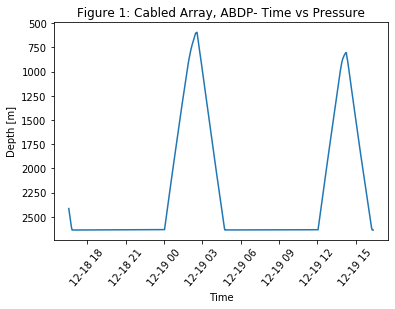

In [8]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
#defines ntp_timezone and disregarding 70 yr offset

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

time7=[]
for i in range(len(ABDP_time)):
    time7.append(ntp_seconds_to_datetime(ABDP_time[i]))
    
plt.plot(time7,pres)
plt.gca().invert_yaxis() #Code to reverse depth
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title('Figure 1: Cabled Array, ABDP- Time vs Pressure')
plt.xticks(rotation=50)


Looking at the number of dives above, we notice that there are two. Confirming it is shown below:

In [9]:
#Using data referenced from Matthew on 1/29/2020
def total_dives(pres):
    minimum_depth =max(pres)
    maximum_depth = False
    divecount = 0
    
    for i in range(0,len(pres)):
        if(pres[i]>0.95*minimum_depth and not maximum_depth):
            maximum_depth = True
        
        if(pres[i]<0.95*minimum_depth and maximum_depth):
            maximum_depth = False
            divecount +=1
    return divecount

print("Total dives within 24 hours of Axial Base Deep Profiler is = ",total_dives(pres))

Total dives within 24 hours of Axial Base Deep Profiler is =  2


In [11]:
#Defining speed of sound
c =1449.2+4.6*(T)-0.055*(T)**2+0.00029*T**3+(1.34-.01*T)*(sal-35)+0.016*pres
c_max = max(c)
print("Maximum speed of sound is ", c_max, "m/s")


Maximum speed of sound is  1499.060874418298 m/s


Text(0.5, 1.0, 'Figure 2: Cabled Array, ABDP- Pressure (dbar) vs SSP')

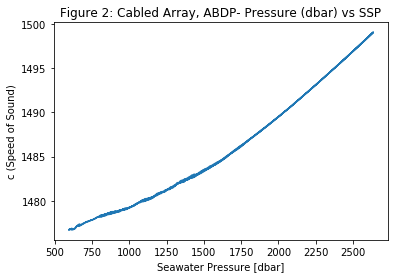

In [37]:
plt.plot(pres , c)
plt.xlabel('Seawater Pressure [dbar]')
plt.ylabel('c (Speed of Sound)')
plt.title('Figure 2: Cabled Array, ABDP- Pressure (dbar) vs SSP')


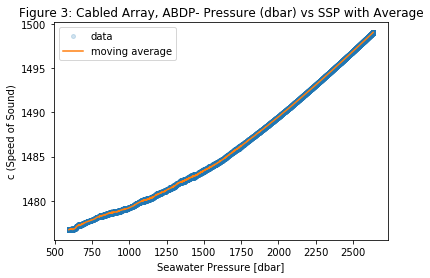

In [41]:
#define a moving average function
plt.plot(pres,c,'o',alpha=0.2,ms=4,label='data')
def moving_average(pres,c,step_size=0.1,bin_size=1):
    bin_centers = np.arange(np.min(pres),np.max(pres)-0.5*step_size,step_size)+0.5*step_size
    bin_avg = np.zeros(len(bin_centers))
    
    for index in range(0,len(bin_centers)):
        bin_center = bin_centers[index]
        items_in_bin = c[(pres>(bin_center-bin_size*0.5) ) & (pres<(bin_center+bin_size*0.5))]
        bin_avg[index] = np.mean(items_in_bin)
    return bin_centers,bin_avg

#plot the moving average
bins, average = moving_average(pres,c)
plt.plot(bins, average,label='moving average')
plt.xlabel('Seawater Pressure [dbar]')
plt.ylabel('c (Speed of Sound)')
plt.title('Figure 3: Cabled Array, ABDP- Pressure (dbar) vs SSP with Average')
plt.legend()
plt.show()

#Please wait a moment, takes a lil while to publish for slower computers